In [46]:
import numpy as np
import pickle

from negative_sampling_layer import UnigramSampler, NegativeSamplingLoss
from common.layers import Embedding, SigmoidWithLoss
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu, most_similar, analogy
from dataset import ptb

# 4 word2vec 속도 개선

앞의 CBOW는 corpus의 어휘량이 늘어나면 계산량이 너무 커진다. 

2가지 방법으로 속도 개선을 하겠다 
- Embedding 계층 도입
- Negative Sampling이라는 새로운 손실 함수 도입

## 4.1 word2vec 개선 1

어휘가 100만개, 은닉층 뉴런이 100개인 경우 
- 입력층의 원핫표현과 가중치 `W_in`의 곱 계산: Embedding 계층으로 해결
- 은닉층과 가중치 `W_out`의 곱 및 Softmax의 계산: Negative Sampling으로 해결

에서 병목이 생긴다. 

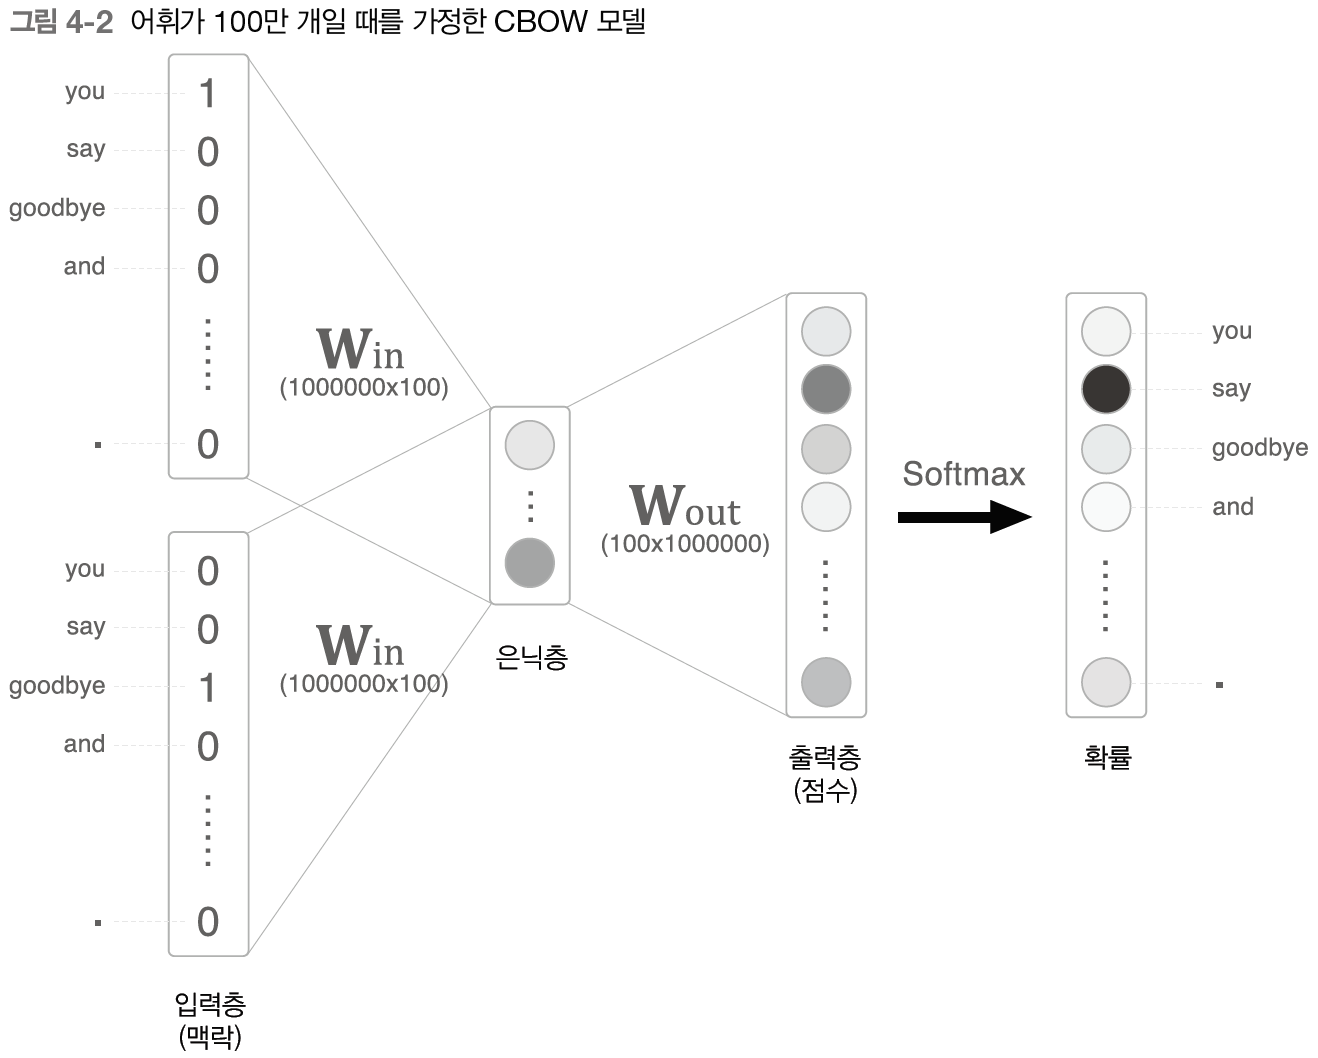

### 4.1.1 Embedding 계층

기존 방법에서 `np.dot(c, W_in)`을 하는 것은 단순히 `W_in`의 특정 row == 어떤 단어의 가중치 를 뽑아내는 과정에 지나지 않는데, 여기에 연산력을 낭비하는 것이 문제. 

Embedding 계층을 통해 단어ID에 해당하는 row(vector)를 추출하겠다. 

NLP에서 단어의 밀집벡터 표현을 word embedding 또는 distributed representation(분산표현) 이라고 부른다. Embedding Layer는 여기서 유래했다. 

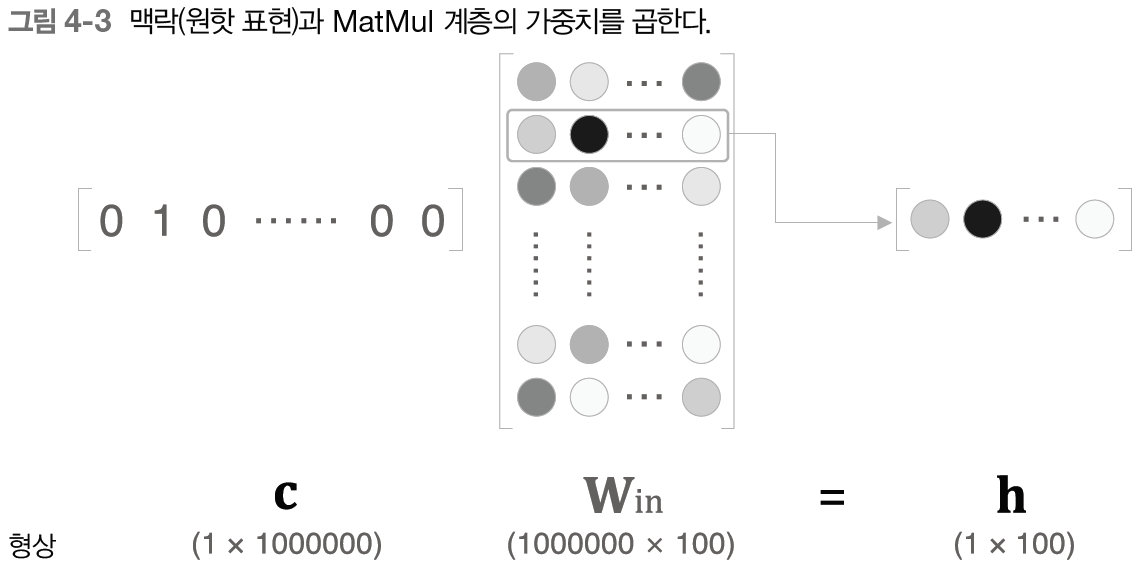

### 4.1.2 Embedding 계층 구현

In [2]:
W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [3]:
W[2] # 간단히 행 꺼낼 수 있음. 

array([6, 7, 8])

In [4]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [5]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
    
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

역전파는 어떻게 될까? Embedding의 순전파는 그냥 W의 특정 행만 추출해준다. 따라서 역전파도 기울기를 그대로 흘려주기만 하면 된다. 

다만, 앞 층에서 온 기울기를 idx번째 행에 dW로 설정해주기만 하면 된다. 

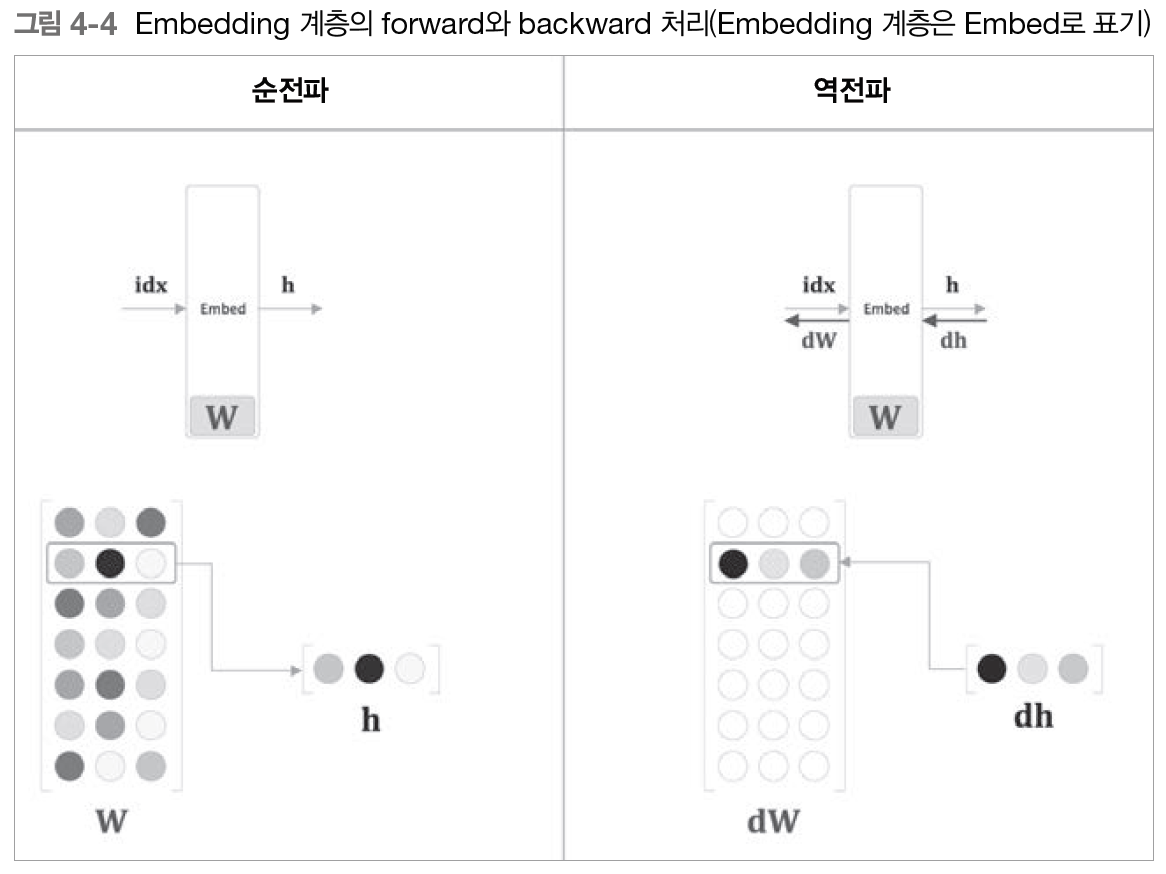

In [6]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
    
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW = self.grads
        dW[...] = 0
        dW[self.idx] = dout # 실은 나쁜 예
        return None

여기서 `dW[...] = 0` 은 `dW`의 형상을 유지하며 원소에 0을 덥어씌우는 것이다. 

이렇게 하고 `dW`에 `self.idx`를 할당하는 것이 나쁜 예인 이유는 애초에 `W`에서 가중치를 갱신하고 싶은 것이기 때문에 새로 `dW`를 만들어 `dout` 값들을 채우는 것이 아니라 그냥 `W`에서 특정 `idx`가 어떤 `dout`로 갱신되는지만 따로 기록하고 기존 `W`에서 갱신하면 되기 때문이다. 

또한, `idx = [0, 2, 0, 4]`인 경우처럼 같은 행이 여러 번 나올 때도 갱신이 되는게 아니고 덮어씌워지기 때문에 문제가 생긴다. 따라서 '할당'이 아닌 '더하기'를 해야한다. 

In [7]:
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [8]:
idx = np.array([0, 2, 0, 4])

In [9]:
W[idx] = [[1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]]
W # 0번째 row는 덮어씌워졌다. 

array([[ 3,  3,  3],
       [ 3,  4,  5],
       [ 2,  2,  2],
       [ 9, 10, 11],
       [ 4,  4,  4],
       [15, 16, 17],
       [18, 19, 20]])

In [10]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
    
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW = self.grads
        dW[...] = 0
        
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
            # 또는
            # np.add.at(dW, self.idx, dout)
        return None

## 4.2 word2vec 개선 2

Negative Sampling 방식으로 은닉층 이후의 행렬곱/softmax 연산 병목을 처리할 수 있다. 

Softmax 대신 Negative Sampling을 이용하면 어휘가 아무리 많아져도 계산량을 낮은 수준에서 억제할 수 있다. 

### 4.2.1 은닉층 이후 계산의 문제점

### 4.2.2 다중 분류에서 이진 분류로

Negative Sampling의 핵심은 multi-class classification을 binary classification로 근사하는 것이다. 

100만개의 단어 중 무엇일까? 가 아니고 맥락이 'you'와 'goodbye'일 때 target 단어는 'say'인가? 라는 Yes/No 답변이 가능한 질문으로 바꾸는 것이다.

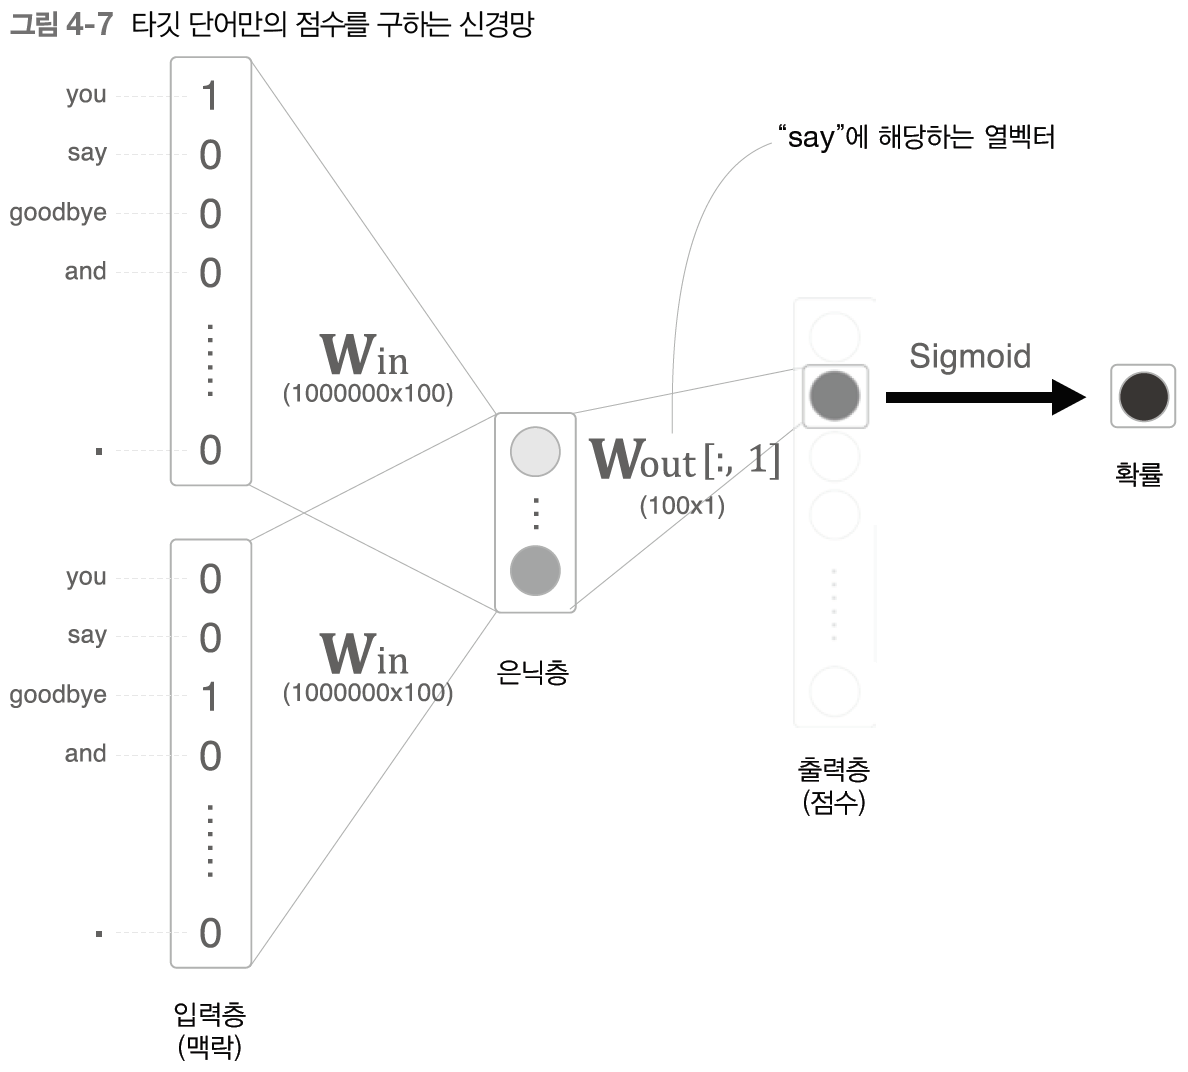

`W_out`이 100*1 벡터인 것을 주목하자. 출력층 또한 1개 뉴런이 끝이다. 

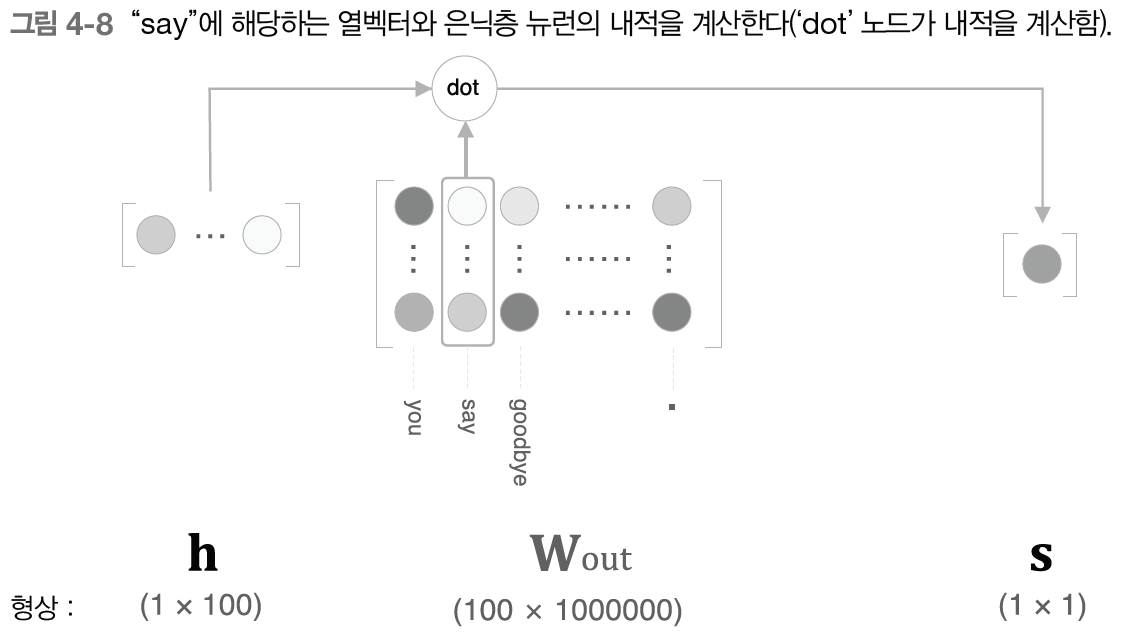



### 4.2.3 시그모이드 함수와 교차 엔트로피 오차

주로 다중 분류는 소프트맥스-교차엔트로피오차 를 이용하고, 이진 분류는 시그모이드-교차엔트로피오차 를 이용한다. 

교차엔트로피 오차: 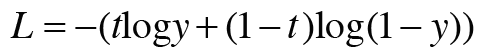

식을 분해해보면, `t==1` 일때 정답, `t==0`일 때 오답이다. `L`을 최소화 하는 것이 목적이고 항상 `y < 1`, `log(y) < 0 & log(1-y) < 0` 이므로, 

- 맞았을 때는 `t==1`니까 classification의 확률 `y`이 높다면 `L = -log(y)` (양수) 가 된다. 
- 반대로 틀렸을 때는 `t==0`이니까 classification 화률 `y`가 낮아야 좋다. 만약 `y`가 높다면 `-log(1-y)`의 값이 매우 커지고, Loss가 커지게 된다. 

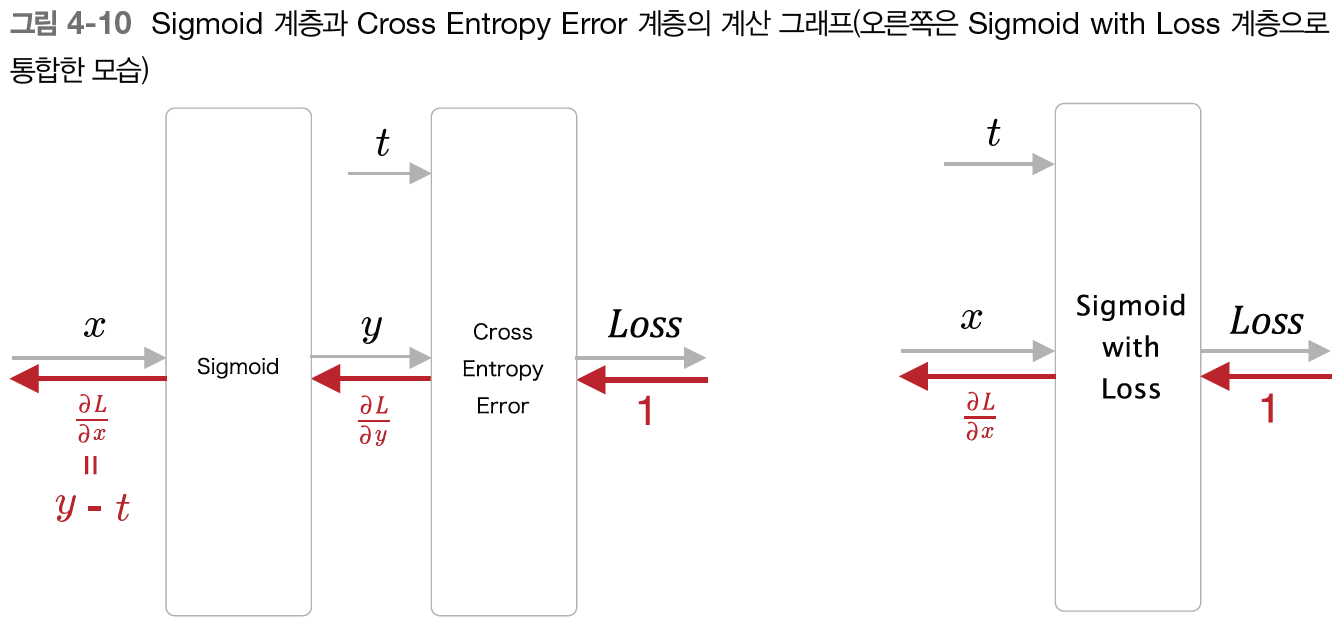

`aL/ax = y-t`가 되는 이유는:
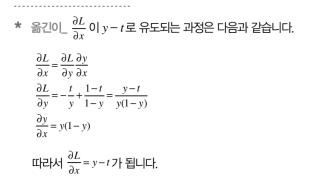

### 4.2.4 다중 분류에서 이진 분류로 (구현)

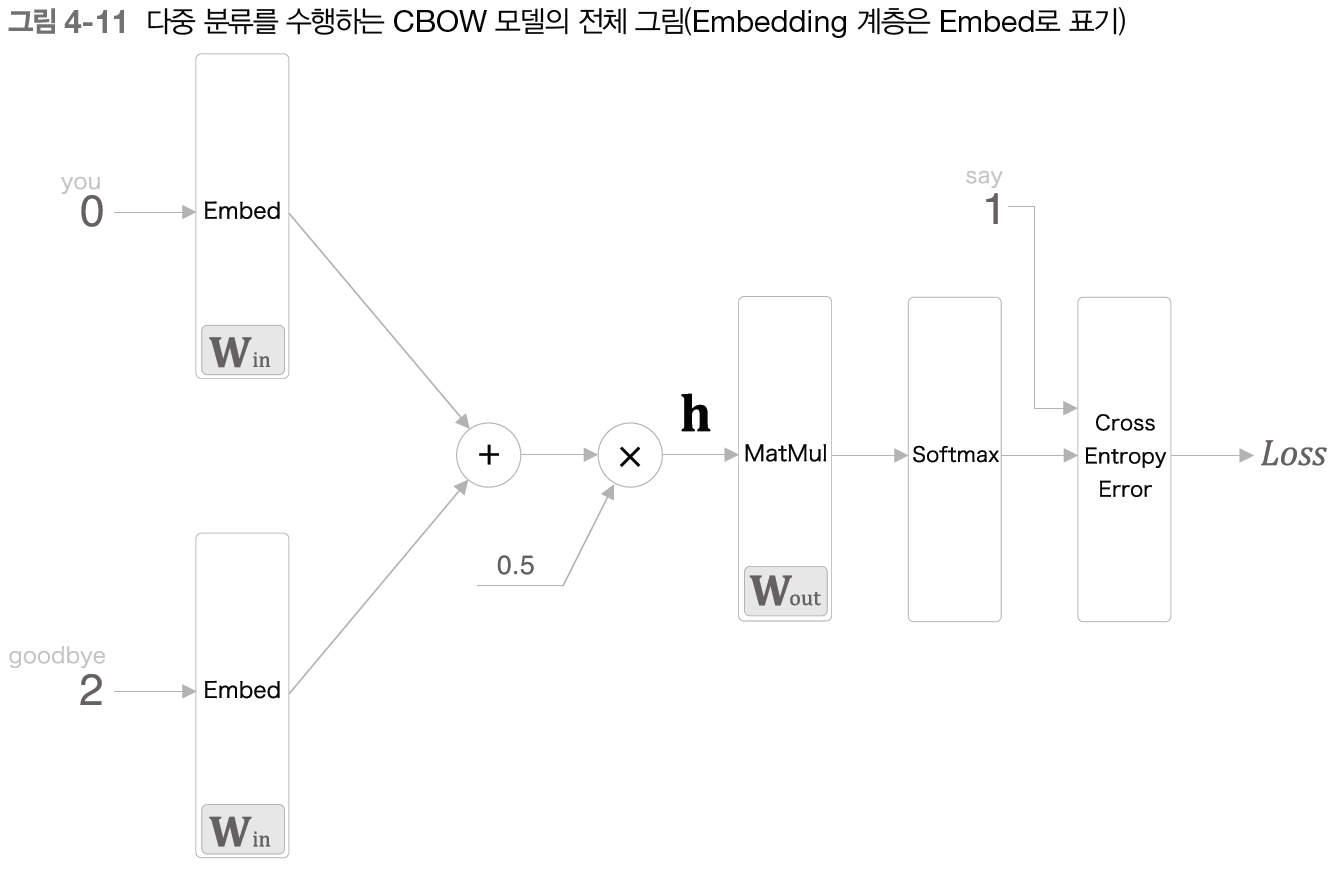

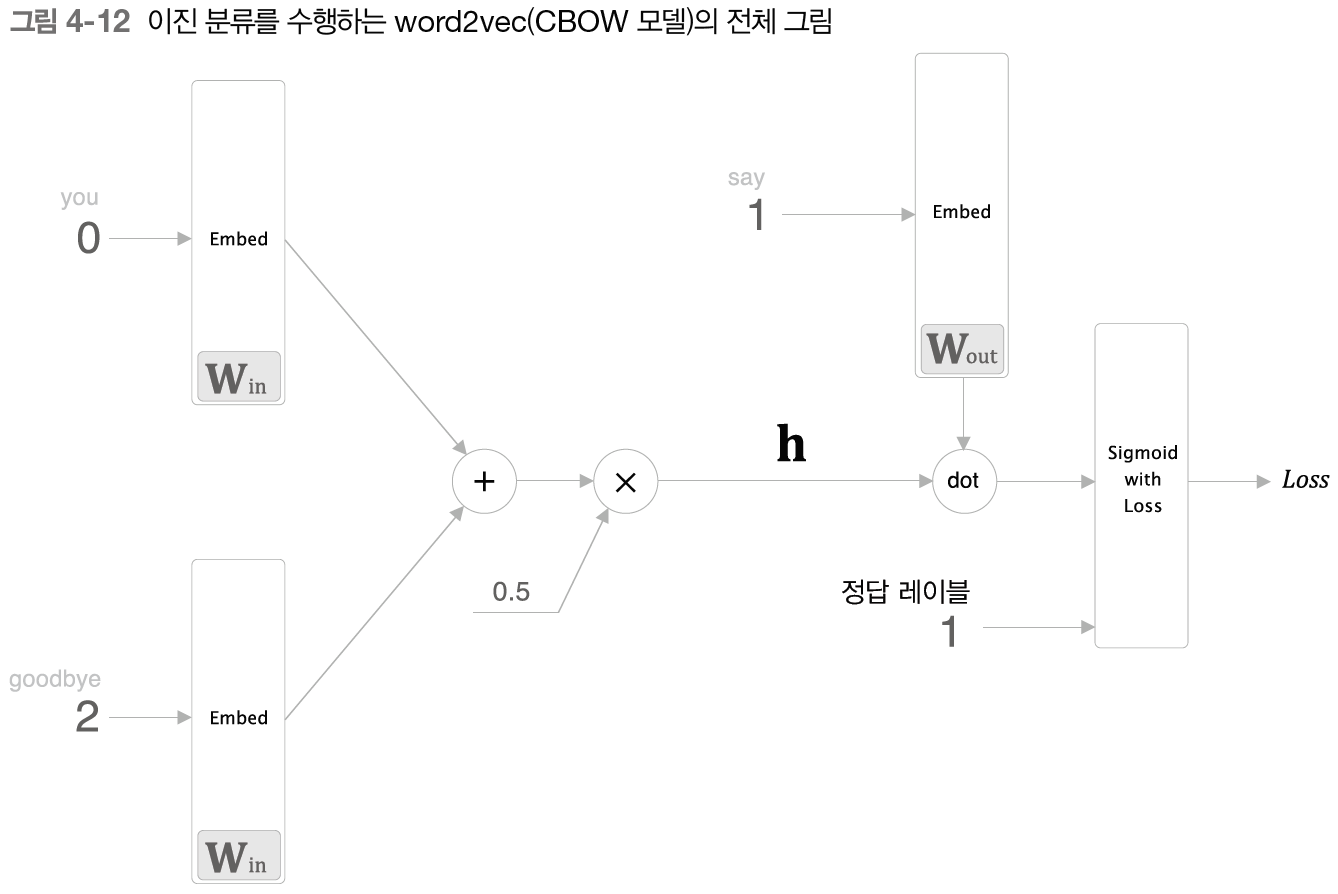

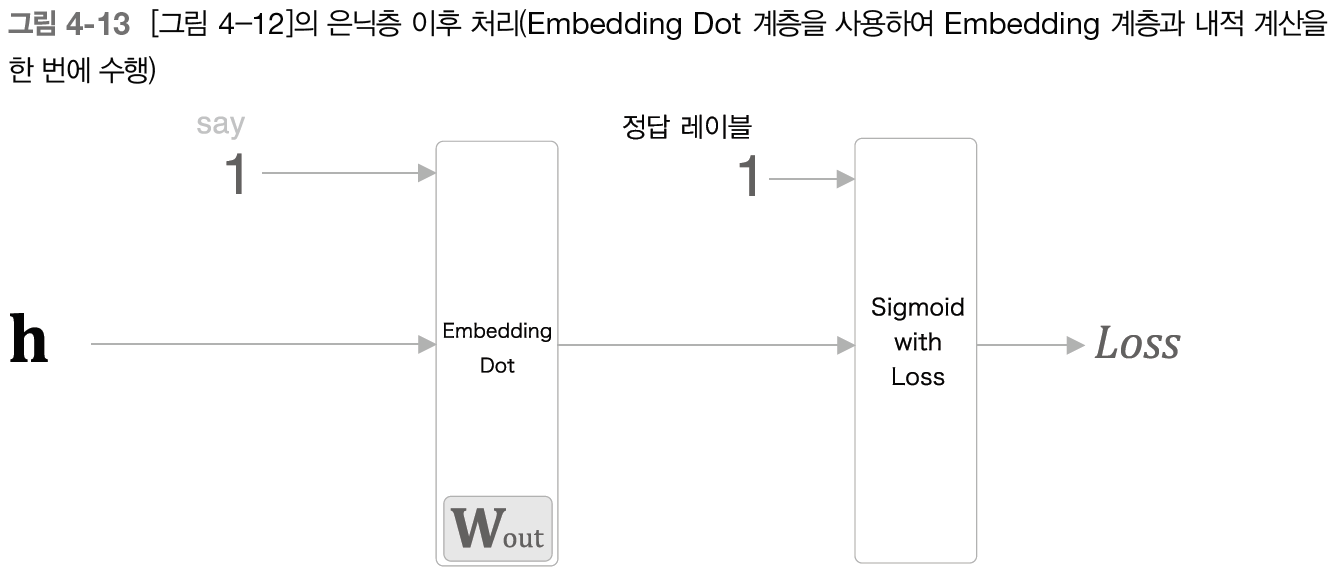

In [11]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params # 매개변수 저장
        self.grads = self.embed.grads # 기울기 저장
        self.cache = None # 순전파의 계산결과를 잠시 유지
        
    def forward(self, h, idx): # 은닉층 뉴런과 단어 id의 넘페이 row를 같이 받는다. idx는 배열인데, 여러 개를 처리하는 미니배치를 가정했기 때문이다. 
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * taget_W
        return dh

### 4.2.5 네거티브 샘플링

긍정적 예제에 대해 학습했으니, 부정적 예제에 대해서도 학습해야 한다. 

정답은 sigmoid 출력이 1에 가까워야 하고 오답은 출력이 0에 가까워야 한다. 

이 때, 모든 부정적 예제에 대해 학습시키려고 하면 negative sampling의 의미가 없다. 앞에서 한 것처럼 모든 예제에 대해 다 계산하는 것이 되기 때문이다. 

따라서 근사적으로 부정적 예를 몇 개 샘플링 한다. 

그리고 긍정적 예의 손실 + 부정적 예의 손실 을 하여 최종 손실을 만들어낸다. 

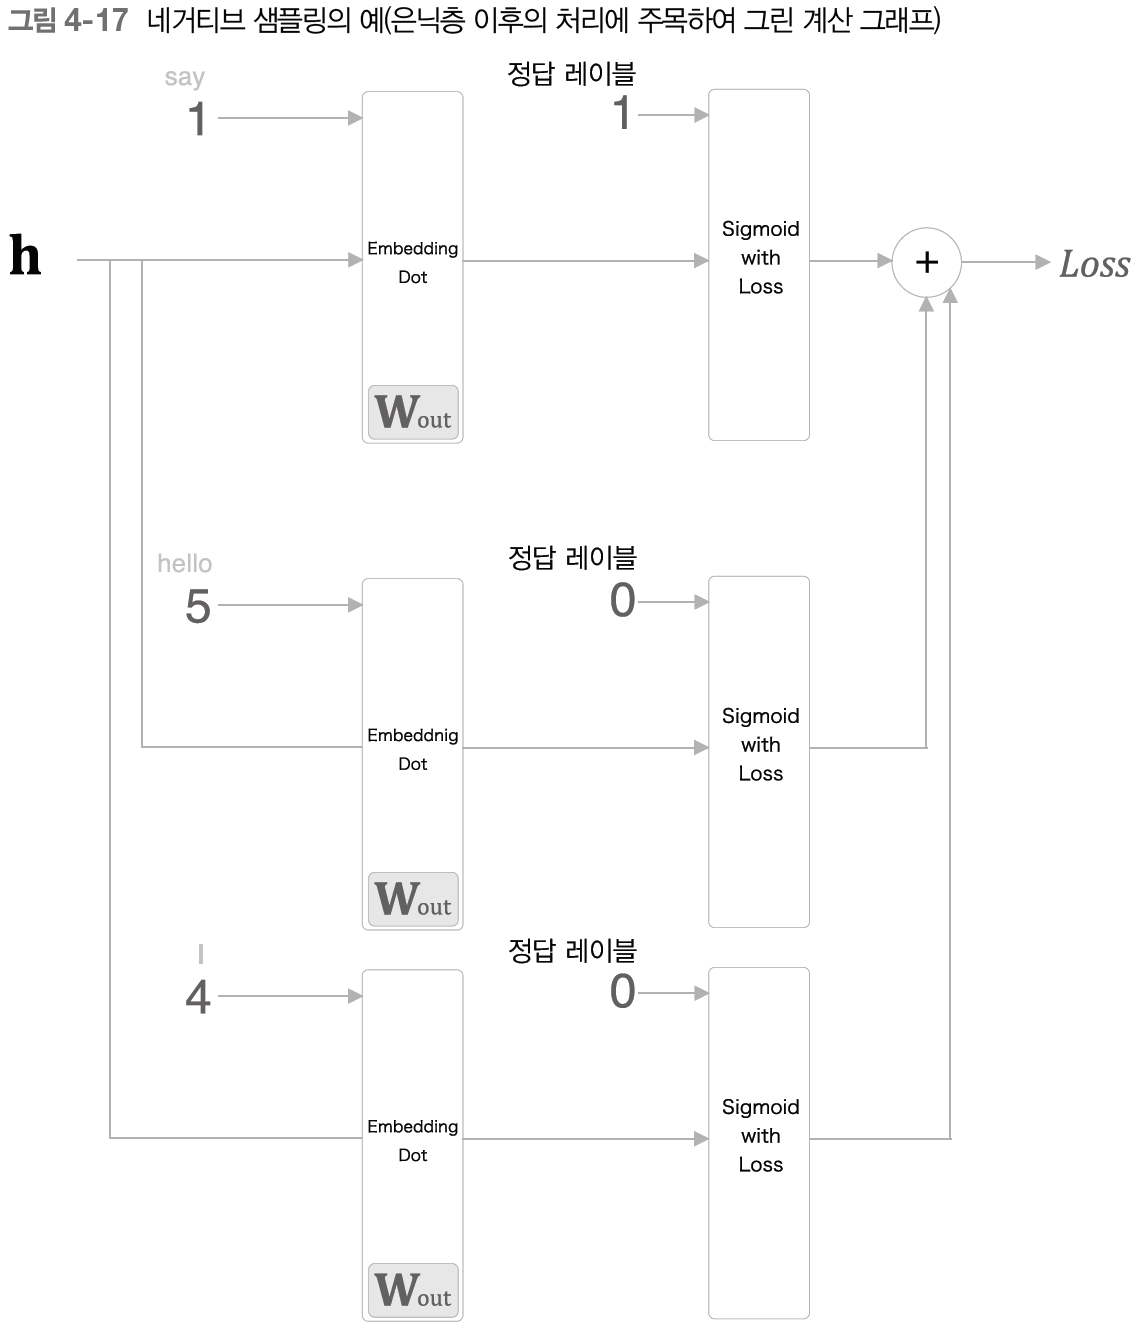

### 4.2.6 네거티브 샘플링의 샘플링 기법

부정적 예를 샘플링 할 때는 통계적 데이터를 활용한다. 

자주 등장하는 단어는 많이 추출하고 드물게 등장하는 단어는 적게 추출한다. 

corpus에서 각 단어의 출현회수를 히스토그램으로 그리고 그 확률분포대로 sampling하면 된다. 

In [12]:
# 0~9 사이의 숫자 하나를 무작위로 샘플링

np.random.choice(10)

3

In [13]:
# words에서 하나만 무작위로 샘플링

words = ['you', 'say', 'goodbye', 'I', 'hello', '.'] # unique하다. 
np.random.choice(words)

'goodbye'

In [14]:
# 5개를 무작위로 샘플링 (중복 있음.)

np.random.choice(words, size=5)

array(['.', 'I', 'goodbye', 'you', 'say'], dtype='<U7')

In [15]:
# 5개를 무작위로 샘플링 (중복 없음.)

np.random.choice(words, size=5, replace=False)

array(['hello', 'goodbye', 'you', 'I', 'say'], dtype='<U7')

In [16]:
# 확률 분포에 따라 샘플링

p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'goodbye'

그런데 word2vec에선 통계적 확률분포에서 0.75승 할 것을 권하고 있다. 

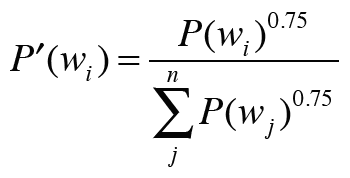

이렇게 수정하는 이유는 출현확률이 낮은 단어의 확률을 살짝 높여줄 수 있다. 


In [17]:
p = [0.7, 0.29, 0.01]

new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)

new_p # 높은 확률은 낮아지고 낮은 확률은 높아짐. 

array([0.64196878, 0.33150408, 0.02652714])

unigram이 아닌 n-gram으로 만들었을 때도 비슷한 방법을 써주면 된다. 

In [18]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3,])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0]) # 긍정적 예
negative_sample = sampler.get_negative_sample(target) # 각 데이터에 대한 부정적 예
negative_sample

array([[2, 3],
       [2, 4],
       [4, 3]])

### 4.2.7 네거티브 샘플링 구현

In [19]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size # 부정적 예의 샘플링 횟수
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] # 부정적 예시의 계층 sample_size개 + 긍정적 예시의 계층 1개
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [], []
        
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads  
    
    def forward(self, h, target): # 은닉층 뉴런 h, 긍정적 타깃 target
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(targer)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32) # 긍정 레이블 정답은 1
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32) # 부정 레이블 정답은 0
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target) # 0번째는 이미 긍정적에서 썼으니까 
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

## 4.3 개선판 word2vec 학습

### 4.3.1 CBOW 모델 구현

앞에서 배운 Embedding 계층과 Negative Sampling Loss 계층을 적용하겠다. 

In [21]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in) # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다. 
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # 인스턴스 변수에 단어의 반산 표현을 저장한다. 
        self.word_vecs = W_in # 단어의 분산표현도 저장. 가중치가 곧 분산표현이다. 
    
    def forward(self, contexts, target): # 단어 아이디로 contexts, targer을 받는다. 
        h= 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)

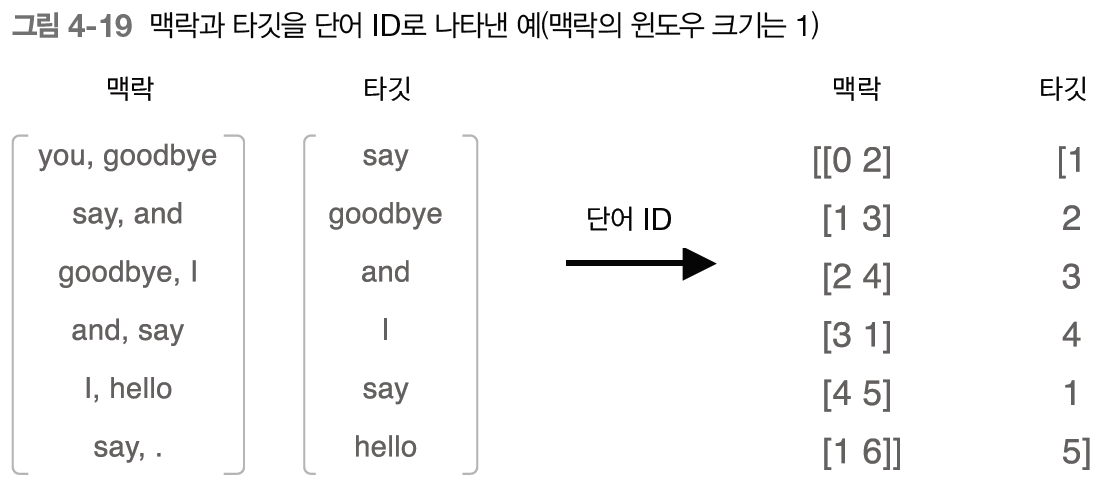

`contexts`, `target`은 이런 형태로 받는다. 

### 4.3.2 CBOW 모델 학습 코드

In [27]:
# hyperparameters

window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

In [32]:
# 데이터 읽기

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

In [36]:
contexts, target = create_contexts_target(corpus, window_size)

In [37]:
# 모델 등 생성

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| 에폭 1 |  반복 1 / 251 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 251 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 251 | 시간 2[s] | 손실 4.15
| 에폭 1 |  반복 61 / 251 | 시간 3[s] | 손실 4.09
| 에폭 1 |  반복 81 / 251 | 시간 5[s] | 손실 3.97
| 에폭 1 |  반복 101 / 251 | 시간 6[s] | 손실 3.79
| 에폭 1 |  반복 121 / 251 | 시간 7[s] | 손실 3.59
| 에폭 1 |  반복 141 / 251 | 시간 8[s] | 손실 3.40
| 에폭 1 |  반복 161 / 251 | 시간 9[s] | 손실 3.25
| 에폭 1 |  반복 181 / 251 | 시간 11[s] | 손실 3.12
| 에폭 1 |  반복 201 / 251 | 시간 12[s] | 손실 3.00
| 에폭 1 |  반복 221 / 251 | 시간 13[s] | 손실 2.95
| 에폭 1 |  반복 241 / 251 | 시간 14[s] | 손실 2.88
| 에폭 2 |  반복 1 / 251 | 시간 15[s] | 손실 2.83
| 에폭 2 |  반복 21 / 251 | 시간 16[s] | 손실 2.78
| 에폭 2 |  반복 41 / 251 | 시간 17[s] | 손실 2.74
| 에폭 2 |  반복 61 / 251 | 시간 19[s] | 손실 2.73
| 에폭 2 |  반복 81 / 251 | 시간 20[s] | 손실 2.69
| 에폭 2 |  반복 101 / 251 | 시간 21[s] | 손실 2.68
| 에폭 2 |  반복 121 / 251 | 시간 22[s] | 손실 2.68
| 에폭 2 |  반복 141 / 251 | 시간 23[s] | 손실 2.68
| 에폭 2 |  반복 161 / 251 | 시간 25[s] | 손실 2.67
| 에폭 2 |  반복 181 / 251 | 시간 26[s] | 손실 2.69
| 에폭 2 | 

C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jaepil\Ana

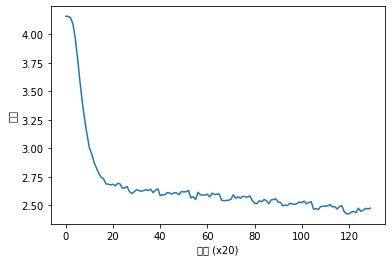

In [38]:
# 학습 시작

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [40]:
# 나중에 사용할 수 있도록 필요한 데이터 저장

word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

말뭉치에 따라 다르나, `window_size`는 2 ~ 10개, 은닉층 뉴런 수(`hidden_size`)는 (단어 분산표현의 차원수) 50 ~ 500개 정도면 좋은 결과를 얻는다. 

### 4.3.3 CBOW 모델 평가

In [44]:
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

    
# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


`word_vecs` 를 이용하여 단순 통계적 발생빈도가 아닌 유추문제(analogy)를 풀어볼 수 있다. 

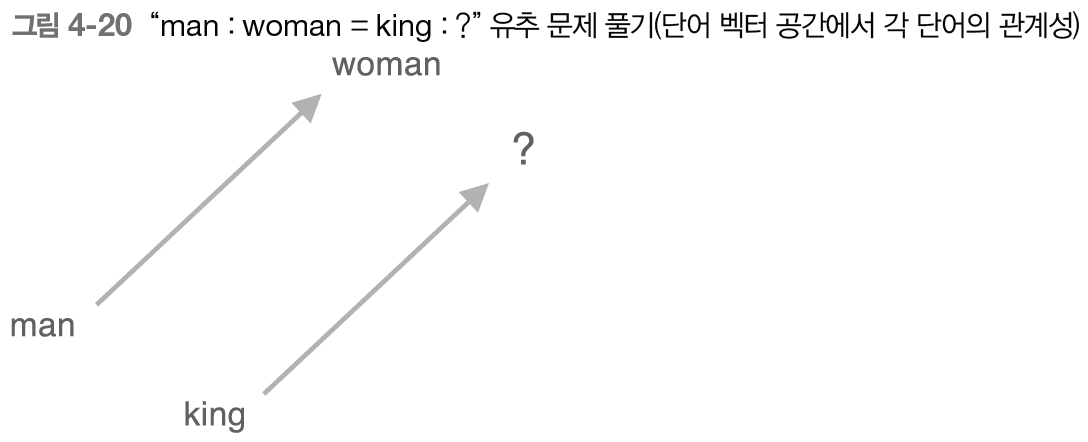

man: woman = king : ? 

man --> woman 벡터와 king --> ? 벡터가 가장 가까워지는 ?를 찾는다. 

이는 vec('woman') - vec('man') = vec(?) - vec('king') 를 계산하여 구할 수 있다. 

In [47]:
# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slower: 4.734375
 greater: 4.671875


## 4.4 word2vec 남은 주제

### 4.4.1 word2vec을 사용한 어플리케이션의 예

비슷한 단어를 찾는 용도로 사용될 수 있음 (obvious)

그보다, 전이 학습 (transfer learning)이 가능하다는 점에서 중요함. 즉, 이미 학습된 word2vec을 다른 용도로 사용할 수 있다는 것. 

단어를 고정길이 벡터로 표현하는 것을 넘어, 문장을, 문서를 고정 길이 벡터로 변환할 수도 있음. 

문장을 변환하는 가장 간단한 방법은 각 단어를 분산표현으로 변환하고 그 합을 구하는 것. (bag-of-words, 단어의 순서를 고려하지 않음.)

때문에 뒤의 RNN에서 순서를 고려하여 문장을 벡터로 나타낼 것임. 

이렇게 자연어를 vectorize시킬 수 있다는 것은, 이것을 다른 머신러닝에서 학습에 이용할 수 있다는 뜻이기 때문에 매우 중요함. 


### 4.4.2 단어 벡터 평가 방법

어플리케이션의 성능 != 단어 분산표현의 성능

단어 분산표현은 주로 유사성/유추문제로 평가한다. 

인간이 분류한 정답레이블 유사도 test set을 가지고 평가한다. Metric은 다음과 같다. 
- 의미(semantics): king-queen 처럼 문법이 아닌 사회적 의미적으로 반대되는 사항을 말하는 듯. 
- 구문(syntax): 비교급, 단수 복수 이런 문법적인 사항을 말하는 듯.

분산표현을 검증한 결과 다음 사항을 알 수 있다. 
- 말뭉치에 따라 적합한 모델을 써야. 모델에 따라 정확도 다르다. CBOW? skip-gram? 
- 일반적으로 말뭉치는 클수록 좋다. 데이터 다다익선
- 단어 벡터 차원 수는 적당해야 좋다. 너무 크면 정확도가 떨어진다. 당연할 것이다. curse of dimensionality가 있으니까. 

## 4.5 정리

- Embedding 계층은 단어의 분산 표현을 담고 있으며, `.forward`시 지정한 `word_id`의 벡터를 추출한다. 
- word2vec은 어휘 수의 증가에 비례해 계산량도 증가하므로, 근사치로 계산하는 빠른 기법을 사용하면 좋다. 
- 네거티브 샘플링은 부정적 예를 몇 개 샘플링하는 기법으로, 이를 이용하면 다중 분류를 이진 분류처럼 취급할 수 있다. 
- word2vec으로 얻은 단어의 분산 표현에는 단어의 의미가 녹아들어 있으며, 비슷한 맥락에서 사용되는 단어는 단어 벡터 공간에서 가까이 위치한다. 
- word2vec의 단어의 분산표현을 이용하면 유추 문제를 벡터의 덧셈과 뺄셈으로 풀 수 있게 된다. 
- word2vec은 transfer learning 측면에서 특히 중요하며, 그 단어의 분산 표현은 다양한 자연어 처리 작업에 이용 할 수 있다. 